# Notebook to load trained models and verify them on some images

In [1]:
import torch
import numpy as np
from torchvision import transforms
from skimage.io import imread
import matplotlib.pyplot as plt
import sys
sys.path.append('../../src/')
from data_process import *
from u2net import *
from unet import *
from resnest import *

# One model

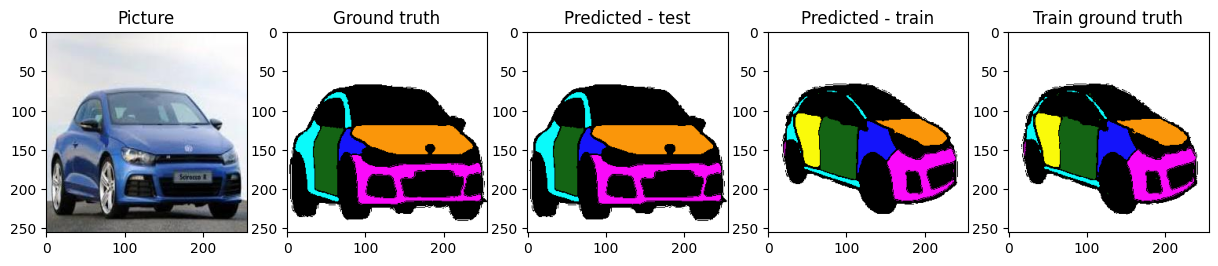

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load("../../trained_models/unet.pt", map_location=device)
model.eval()

if __name__ =='__main__':
    ########## Connected ####################
    path_to_seg_img = "../data/good_test/photo_0006.npy"
    path_to_no_seg_img = "../data/carseg_data/images/photo/no_segmentation/0006.jpg"
    reference = np.load(path_to_seg_img)[:,:,:3]
    ref_mask = np.load(path_to_seg_img)[:,:,3]
    #########################################
    
    ########## Connected ####################
    path_to_seg_img = "../data/carseg_data/arrays/photo_0163.npy"
    path_to_no_seg_train = "../data/carseg_data/images/photo/no_segmentation/0163.jpg"
    train = imread(path_to_no_seg_train)
    train_mask = np.load(path_to_seg_img)[:,:,3]
    #########################################
    
    imgA = imread(path_to_no_seg_img)
    imgA = resize_2_256(imgA)
    imgB = imread(path_to_no_seg_train)
    imgB = resize_2_256(imgB)

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                         std=[0.229, 0.224, 0.225])])
    imgA = transform(imgA)
    imgA = imgA.to(device)
    imgA = imgA.unsqueeze(0)
    imgB = transform(imgB)
    imgB = imgB.to(device)
    imgB = imgB.unsqueeze(0)
    
    if model.name == "U2NET":
        output1, _,_,_,_,_,_ = model(imgA)
        out2, _,_,_,_,_,_ = model(imgB)
    else:
        output1 = model(imgA) # Rest
        out2 = model(imgB)

    output_np1 = output1.cpu().detach().numpy().copy()  # output_np1.shape = (1, 10, 256, 256)
    output_np1 = (np.argmax(output_np1, axis=1) * 10).astype(np.uint8)
    out_np2 = out2.cpu().detach().numpy().copy()  # output_np1.shape = (1, 10, 256, 256)
    out_np2 = (np.argmax(out_np2, axis=1) * 10).astype(np.uint8)
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 5, 1)
    plt.title("Picture")
    plt.imshow(reference)
    plt.subplot(1, 5, 2)
    plt.title("Ground truth")
    plt.imshow(label_2_colour(ref_mask))
    plt.subplot(1, 5, 3)
    plt.title("Predicted - test")
    plt.imshow(label_2_colour(output_np1[0]))
    plt.subplot(1, 5, 4)
    plt.title("Predicted - train")
    plt.imshow(label_2_colour(out_np2[0]))
    plt.subplot(1, 5, 5)
    plt.title("Train ground truth")
    plt.imshow(label_2_colour(train_mask))


# Comparison

In [2]:
def loadMultiple(modelnames):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    models = []
    for name in modelnames:
        model = torch.load(name, map_location=device)
        models.append(model)
    
    return models

In [24]:
def inspectMultiple(models, n_in_test=10):
    arrays = np.load("../data/test.npy")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Define the image and mask
    ref = arrays[n_in_test][:,:,:3]
    img = arrays[n_in_test][:,:,:3]
    mask = arrays[n_in_test][:,:,3]
    
    transform = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
    img = transform(img)        # Transform the image
    img = img.to(device)      
    img = img.unsqueeze(0)

    # Load all models and perform predictions
    predictions = {"Picture" : ref, "Ground truth" : mask}
    for model in models:
        model.eval()
        # Perform predictions
        if model.name == "U2NET":
            prediction, _,_,_,_,_,_ = model(img)
            pred_np = prediction.cpu().detach().numpy().copy()  # pred_np.shape = (1, 10, 256, 256)
            pred_np = (np.argmax(pred_np, axis=1) * 10).astype(np.uint8)
            predictions[model.name] = pred_np[0]
        else:
            prediction = model(img)
            pred_np = prediction.cpu().detach().numpy().copy()  # pred_np.shape = (1, 10, 256, 256)
            pred_np = (np.argmax(pred_np, axis=1) * 10).astype(np.uint8)
            predictions[model.name] = pred_np[0]
    
    # Display results
    n = len(models)
    _, ax = plt.subplots(1, n+2, figsize=(5*(n+2), 5))
    ax[0].imshow(predictions["Picture"])
    ax[0].set_title('Image')
    ax[1].imshow(label_2_colour(predictions["Ground truth"]))
    ax[1].set_title('Ground truth')
    for i in range(n):
        ax[i+2].imshow(label_2_colour(predictions[models[i].name]))
        ax[i+2].set_title(f'Predicted {models[i].name}')

    plt.show()


In [4]:
modelNames = ["../trained_models/posterchildren/UNET_60_loss_trian_0.00581_val_0.00786.pt", "../trained_models/posterchildren/ResNeSt50_120_loss_trian_0.00818_val_0.02187.pt",
              "../trained_models/posterchildren/ResNeSt101_120_loss_trian_0.01452_val_0.01132.pt", "../trained_models/posterchildren/ResNeSt200_150_loss_trian_0.01312_val_0.01157.pt", 
              "../trained_models/posterchildren/U2NET_70_loss_trian_0.06932_val_0.07854.pt"]
models = loadMultiple(modelNames)

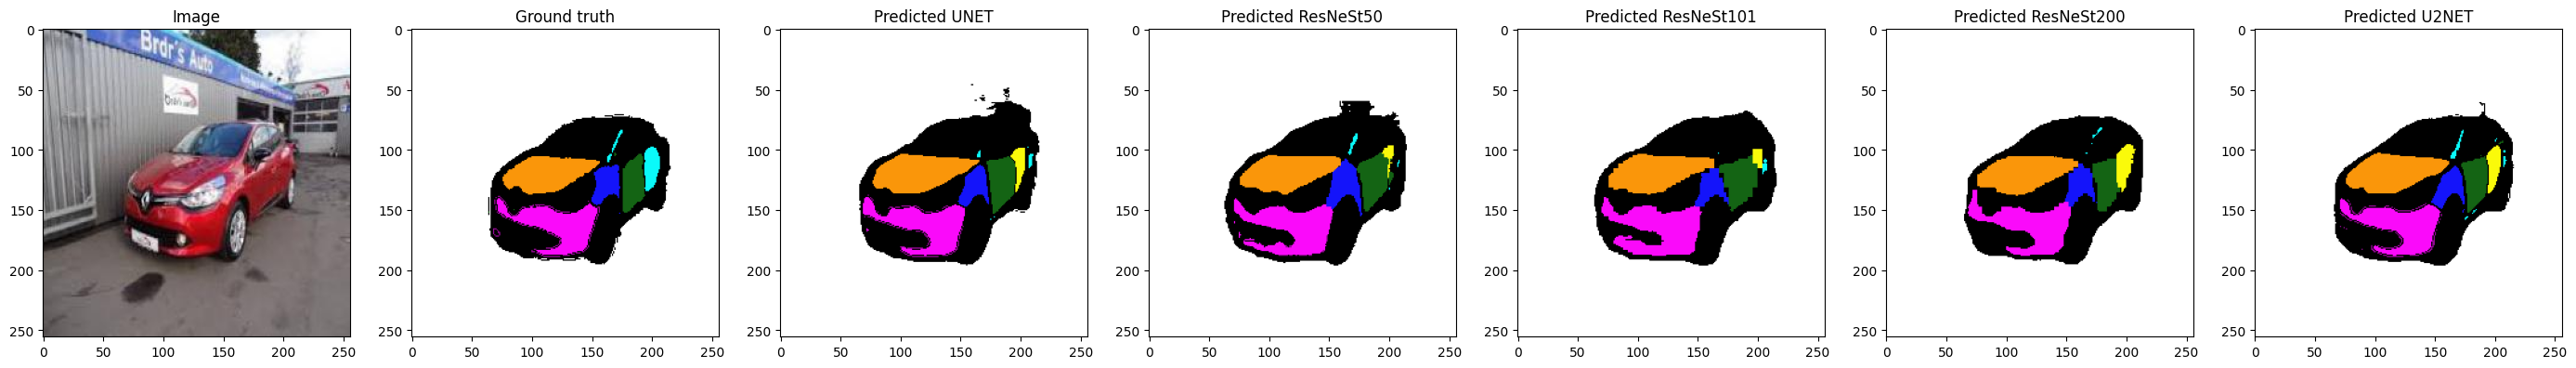

In [26]:
preds = inspectMultiple(models, n_in_test=29)